### Book generator
Network are learned to predict next letter in a book.
After that it creates its own stories by passing output letter to input.
Inspired by [article](karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy

Here we set up plot inlining options and its size:

In [2]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
from IPython import display

Import modules:

In [3]:
import pynn as nn
import pynnui as nnui
import math
from math import floor
from copy import copy
import numpy as np
from matplotlib import pyplot as plt
import signal

Load book:

In [4]:
data = open('data/witcher_rus.txt', 'r', encoding='utf-8').read()
chars = sorted(list(set(data)))

size = len(chars)

print('data length: %d, unique chars: %d' % (len(data), size))
print(chars)

data length: 4508884, unique chars: 141
['\t', '\n', ' ', '!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']


Char to index and back conversion:

In [5]:
ci = { ch:i for i,ch in enumerate(chars) }
ic = { i:ch for i,ch in enumerate(chars) }

Hyperparameters:

In [6]:
seq_len = 25
shid = 100
rate = 1e-1
clip = 5e0

To learn our network we use [BPTT](https://en.wikipedia.org/wiki/Backpropagation_through_time) with [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) plus [AdaGrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad). [Softmax](https://en.wikipedia.org/wiki/Softmax_function) loss is used.

In [7]:
class Entry:
    def __init__(self, ichar, ochar):
        self.ichar = ichar
        self.ochar = ochar

    def getinput(self, buf):
        nn.array.clear(buf)
        buf.np[self.ichar] = 1.

    def getouptut(self, buf):
        nn.array.clear(buf)
        buf.np[self.ochar] = 1.


class Text:
    def __init__(self, text):
        self.text = text

    def __getitem__(self, i):
        return Entry(ci[self.text[i]], ci[self.text[i + 1]])

    def __len__(self):
        return len(self.text) - 1


def BGen(data, seqlen):
    for i in range(0, len(data), seqlen):
        text = data[i:(i + seqlen + 1)]
        if len(text) > 0:
            yield Text(text),


def EGen(data, seqlen):
    while True:
        yield BGen(data, seqlen)

Define recurrent subnetwork:

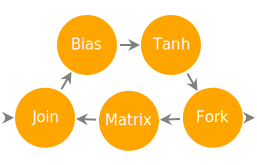

In [8]:
class Feedback(nn.Network):
    def __init__(self, size):
        nn.Network.__init__(self, size, size)
        
        self.addnodes([
            nn.Matrix(size, size),
            nn.Join(size),
            nn.Bias(size),
            nn.Tanh(size),
            nn.Fork(size)
        ])

        self.connect([
            nn.Path(0, (1, 1)),
            nn.Path(1, 2),
            nn.Path(2, 3),
            nn.Path(3, 4),
            nn.Path((4, 1), 0, mem=True),
        ])
        
        self.setinputs((1, 0))
        self.setoutputs((4, 0))

display.SVG(data=nnui.Graph(Feedback(shid)).svg())

Define network structure:

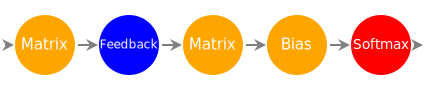

In [9]:
net = nn.Network(size, size)

net.addnodes([
    nn.Matrix(size, shid),
    Feedback(shid),
    nn.Matrix(shid, size),
    nn.Bias(size),
    nn.SoftmaxLoss(size)
])

net.connect([
    nn.Path(0, 1),
    nn.Path(1, 2),
    nn.Path(2, 3),
    nn.Path(3, 4)
])

net.setinputs(0)
net.setoutputs(4)

display.SVG(data=nnui.Graph(net).svg())

In [10]:
factory = nn.array.newFactory()
state = net.newState(factory)

Iterators, counters and state:

In [11]:
class Plotter:
    def __init__(self, bsize, esize, freq, iloss=0.):
        self.bsize = bsize
        self.batch = 0
        self.esize = esize
        self.epoch = 0
        self.freq = freq
        
        self.sloss = iloss
        self.losses = []
        self.epochs = []
        
    def _epoch(self, loss):
        self.epoch += 1
        self.batch = 0
        
    def _batch(self, loss):
        self.sloss = 0.999*self.sloss + 0.001*loss
        self.batch += 1
        if ((self.batch + 1) % self.freq) == 0:
            sepoch = self.epoch + min(1.0, self.batch/self.esize)
            self.epochs.append(sepoch)
            self.losses.append(self.sloss)

            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.plot(self.epochs, self.losses)
            ax.text(sepoch, self.sloss, str(self.sloss))

            display.clear_output(wait=True)

            plt.show()
        
plotter = Plotter(1, (len(data) - 1)//seq_len + 1, 100, -np.log(1/size)*seq_len)

In [28]:
class Watchdog:
    class BMon:
        def __init__(self, outer):
            self.outer = outer
            
        def __call__(self, ctx):
            self.outer._bmon(ctx)
            
    class EMon:
        def __init__(self, outer):
            self.outer = outer
            
        def __call__(self, ctx):
            self.outer._emon(ctx)

    def __init__(self, plotter, imem):
        self.bmon = self.BMon(self)
        self.emon = self.EMon(self)
        self.stop = False
        self.plotter = plotter
        self.imem = imem

    def _bmon(self, teacher):
        # teacher.ctx.getmem(teacher.imem)
        self.plotter._batch(teacher.ctx.loss)
        if self.stop:
            self.stop = False
            raise StopIteration
            
    def _emon(self, teacher):
        # teacher.imem.set(self.imem)
        self.plotter._epoch(teacher.ctx.loss)
            
    def _stop(self):
        self.stop = True
            
watchdog = Watchdog(plotter, state.newMemory(factory))

In [29]:
teacher = nn.Teacher(
    factory, EGen(data, seq_len), net, state,
    adagrad=True, rate=rate, clip=clip, maxlen=seq_len, 
    bmon=watchdog.bmon, emon=watchdog.emon
)

Main learning loop. You can interrupt it and continue whenever you want.

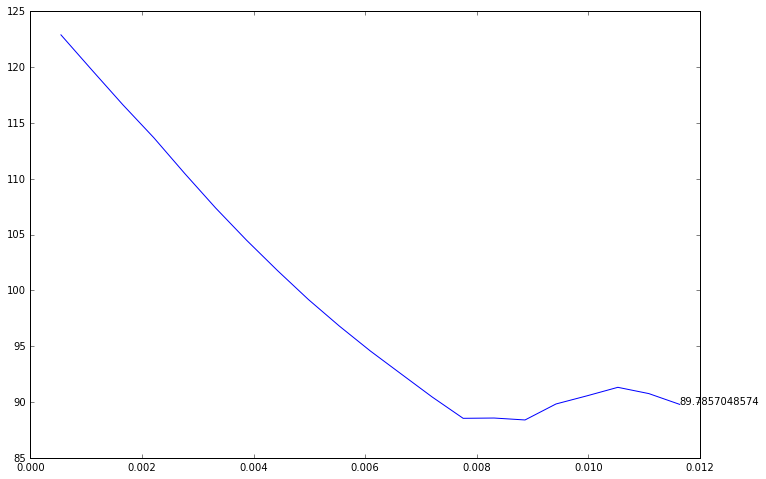

In [30]:
signal.signal(signal.SIGINT, lambda s, f: watchdog._stop())
ctx = teacher.teach()

Generate text from current position and state:

In [31]:
feeder = nn.Feeder(factory, net, ctx.state)

ch = data[plotter.batch*seq_len]
a = ci[ch]
print(ch, end='')
feed = feeder.feed()

for i in range(4000):
    Entry(a, 0).getinput(feeder.src)
    next(feed)
    a = np.random.choice(range(size), p=feeder.dst.get())
    ch = ic[a]

    print(ch, end='')
print()

р																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																							

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in less
